In [ ]:
# Ideas:
    1. Short-term CR more likely to be mechanism; Long-term CR more likely to be effects:
    
        a) get common signature for short-term CR/fasting --> CR mechanism
        b) get common signature for long-term CR --> CR mechanism + CR effects
        c) a & b (intersection) --> maintained CR mechanism
        d) a - b (difference) --> lost CR mechanism
        
    2. Find perturbagen combinations (>2) with large cumulative overlap:
    
        -define score for overlap between short-term CR signature and each perturbagen
        (may want to restrict search to GRAS/neutraceutical perturbagens)
        -choose perturbagen with largest overlap
        -re-define overlap for remaining short-term CR signature and each perturbagen
        -add perturbagen with largest overlap
        -repeat until threshold total overlap reached

In [68]:
#load libraries

library(GEOquery)
library(affy)
library(oligo)
library(stringr)
library(affxparser)
library(tcltk)
library(RColorBrewer)
library(scatterplot3d)
library(limma)

In [67]:
#function definitions

cel_dates <- function(cel_paths) {
    #IN: vector with paths to CEL files
    #OUT: vector of CEL scan dates
    scan_dates <- c()
    for (i in seq_along(cel_paths)) {
        datheader <- readCelHeader(cel_paths[i])$datheader
        scan_date <- gsub(".*([0-9]{2}/[0-9]{2}/[0-9]{2}).*", "\\1", datheader)
        scan_dates[i] <- scan_date       
    }
    return (as.factor(scan_dates))
}


inputs <- function(instructions="", two=F, box1="AL group name", box2="CR group name"){
   #IN:
   #OUT:

   xvar <- tclVar("")
   if (two) {
   yvar <- tclVar("")
   }

   tt <- tktoplevel()
   tkwm.title(tt,"")
   x.entry <- tkentry(tt, textvariable=xvar)
   if (two) {
   y.entry <- tkentry(tt, textvariable=yvar)
   }

   submit <- function() {
     e <- parent.env(environment())   
     x <- as.character(tclvalue(xvar))
     e$x <- x
     if (two) {
     y <- as.character(tclvalue(yvar))
     e$y <- y
     }
     tkdestroy(tt)
   }
   submit.but <- tkbutton(tt, text="Submit", command=submit)
         
   reset <- function() {
     tclvalue(xvar)<-""
     if (two) {
     tclvalue(yvar)<-""
     }
   }
   reset.but <- tkbutton(tt, text="Reset", command=reset)

   tkgrid(tklabel(tt,text=instructions),columnspan=2)
   tkgrid(tklabel(tt,text=box1), x.entry, pady = 10, padx =10)
   if (two) {
   tkgrid(tklabel(tt,text=box2), y.entry, pady = 10, padx =10)
   }
   tkgrid(submit.but, reset.but)

  tkwait.window(tt)
  if (two) {
  return (c(x,y))
  } else {
  return (x)
  }
}

In [69]:
#get raw data
gse_name <- "GSE60596"
data_dir <- paste(getwd(), "data", sep="/")


get_raw <- function (gse_name, data_dir) {
    #IN
    #OUT
    gse_dir <- paste(data_dir, gse_name, sep="/")
    #get raw data
    if (!file.exists(gse_dir)) {
        getGEOSuppFiles(gse_name, baseDir=data_dir)
    }
    #untar
    tar_name <- list.files(gse_dir, pattern="tar")
    untar(paste(gse_dir, tar_name, sep="/"), exdir=gse_dir)
    
    #unzip
    cel_paths <- list.files(gse_dir, pattern=".CEL.gz", full.names=T)
    sapply(cel_paths, gunzip, overwrite=T)   
}

In [70]:
get_raw(gse_name, data_dir)

/home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483027_Mouse_EF_CD-1.CEL.gz 
                                                                                            11118245 
  /home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483028_Mouse_EF_CD-2.CEL.gz 
                                                                                            11124001 
  /home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483029_Mouse_EF_CD-3.CEL.gz 
                                                                                            11128249 
/home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483030_Mouse_EF_CR55-1.CEL.gz 
                                                                                            11119305 
/home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483031_Mouse_EF_CR55-2.CEL.gz 
                                                                                            11117817 
/home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483032_Mouse_EF_CR55-3.CEL.gz 
                                                                                            11134701 
/home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483033_Mouse_EF_CR70-1.CEL.gz 
                                                                                            11123421 
/home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483034_Mouse_EF_CR70-2.CEL.gz 
                                                                                            11129797 
/home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483035_Mouse_EF_CR70-3.CEL.gz 
                                                                                            11120861 
/home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483036_Mouse_EF_CR85-1.CEL.gz 
                                                                                            11121325 
/home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483037_Mouse_EF_CR85-2.CEL.gz 
                                                                                            11124189 
/home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483038_Mouse_EF_CR85-3.CEL.gz 
                                                                                            11133609

In [71]:
load_eset <- function (gse_name, data_dir) {
    #IN
    #OUT
    gse_dir <- paste(data_dir, gse_name, sep="/")
    
    #get GSEMatrix (for pheno data)
    eset <- getGEO(gse_name, destdir=gse_dir, GSEMatrix=T)[[1]]
    
    #load celfiles and normalize
    cel_paths <- list.files(gse_dir, pattern=".CEL", full.names=T)
    data <- tryCatch (
        {
            raw_data <- ReadAffy (celfile.path=gse_dir)
            affy::rma(raw_data)
        },
        warning = function(cond) {
            raw_data <- read.celfiles(cel_paths)
            return (oligo::rma(raw_data))  
        } 
    )
    #rename samples in data
    sampleNames(data) <- str_extract(sampleNames(data), "GSM[0-9]+")
    
    #transfer exprs from data to eset (maintaining eset sample/feature order)
    sample_order <- sampleNames(eset)
    feature_order <- featureNames(eset)
    exprs(eset) <- exprs(data)[feature_order, sample_order]

    #add scan dates to pheno data (maintaining eset sample order)
    scan_dates <- cel_dates (cel_paths)
    names(scan_dates) <- sampleNames(data)
    pData(eset)$scan_date <- scan_dates[sample_order]
    
    #add batch
    
    return (eset)
}

In [72]:
eset <- load_eset(gse_name, data_dir)

ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE60nnn/GSE60596/matrix/
Found 1 file(s)
GSE60596_series_matrix.txt.gz
Using locally cached version: /home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSE60596_series_matrix.txt.gz
Using locally cached version of GPL6246 found here:
/home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GPL6246.soft 
Platform design info loaded.


Reading in : /home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483027_Mouse_EF_CD-1.CEL
Reading in : /home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483028_Mouse_EF_CD-2.CEL
Reading in : /home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483029_Mouse_EF_CD-3.CEL
Reading in : /home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483030_Mouse_EF_CR55-1.CEL
Reading in : /home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483031_Mouse_EF_CR55-2.CEL
Reading in : /home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483032_Mouse_EF_CR55-3.CEL
Reading in : /home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483033_Mouse_EF_CR70-1.CEL
Reading in : /home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483034_Mouse_EF_CR70-2.CEL
Reading in : /home/alex/Documents/Batcave/GEO/caloric-restriction/data/GSE60596/GSM1483035_Mouse_EF_CR70-3.CEL
Reading

In [98]:
sampleNames <- c("AL liver 1", "AL liver 2", "CR liver 1", "CR liver 2",
                 "AL heart 1", "AL heart 2", "CR heart 1", "CR heart 2")

titles <- c("GSM1", "GSM2", "GSM3", "GSM4",
            "GSM5", "GSM6", "GSM7", "GSM8")

pheno <- as.data.frame(sampleNames, titles)

choices <- paste(titles, sampleNames)

,diet.tissue,date,ind
1,AL.liver,a,1
2,AL.liver,b,2
3,CR.liver,a,3
4,CR.liver,b,4
5,AL.heart,a,2
6,AL.heart,b,1
7,CR.heart,a,4
8,CR.heart,b,3


,AL.heart,AL.liver,CR.heart,CR.liver,dateb,ind2,ind3,ind4
1,0,1,0,0,0,0,0,0
2,0,1,0,0,1,1,0,0
3,0,0,0,1,0,0,1,0
4,0,0,0,1,1,0,0,1
5,1,0,0,0,0,1,0,0
6,1,0,0,0,1,0,0,0
7,0,0,1,0,0,0,0,1
8,0,0,1,0,1,0,1,0


,CR.liver - AL.liver,CR.heart - AL.heart
AL.heart,0,-1
AL.liver,-1,0
CR.heart,0,1
CR.liver,1,0
dateb,0,0
ind2,0,0
ind3,0,0
ind4,0,0


In [73]:
diff_expr <- function (eset) {
    #INPUT:
    #OUTPUT:
    
    #BLOCKING VARIABLES:
    #-------------------
    
    #add scan date as blocking variable
    message("Blocking for scan date")
    pData(eset)$scan_date <- letters[pData(eset)$scan_date]  #change needed for makeContrasts
    block_names <- c("scan_date")
    
    #ask if want to add blocking variable?
    choices <- paste(pData(eset)$scan_date, sampleNames(eset), pData(eset)$title)
    i <- 1  #block count
    while (TRUE){
        block <- tk_select.list(c(choices, "YES", "NO"), title="Add blocking variable?")
        if (block != "YES") {break}
        
        #if YES, setup
        block_name <- paste("block", i, sep="_")
        block_names <- c(block_names, block_name)
        pData(eset)[, block_name] <- "level_0"  #baseline level
        i <- i + 1
        
        #select samples in each level of blocking variable (except 1)
        j <- 1  #level count 
        while (TRUE) {
            level <- tk_select.list(choices, multiple=T, title="Select samples in each level (except 1)")    
            level <- str_extract(level, "GSM[0-9]+")
            if (length(level) == 0) {break}  
        
            #add level to pheno
            level_name <- paste("level", j, sep="_")
            pData(eset)[level, block_name] <- level_name
            j <- j + 1
        }
    }

 
    #CONTRASTS:        
    #----------
    
    choices <- paste(sampleNames(eset), pData(eset)$title)
    contrasts <- c()
    group_levels <- c()
    #selected_samples <- c()

    #repeat until all contrasts selected
    while (TRUE) {
        #select AL samples
        AL <- tk_select.list(choices, multiple=T, title="select AL (control) samples for contrast")
        AL <- str_extract(AL, "GSM[0-9]+")
        if (length(AL) == 0) {break}

        #select CR samples
        CR <- tk_select.list(choices, multiple=T, title="select CR (test) samples for contrast")
        CR <- str_extract(CR, "GSM[0-9]+")

        #add group names to pheno
        group_names <- inputs("Enter group names", two=T)
        pData(eset)[AL, "group"] <- group_names[1]
        pData(eset)[CR, "group"] <- group_names[2]

        #add to contrasts
        contrasts <- c(contrasts, paste(group_names[2], group_names[1], sep="-"))

        #add to group_levels
        group_levels <- unique(c(group_levels, group_names[1], group_names[2]))
            
        #add to selected_samples
        #selected_samples <- unique(c(selected_samples, AL, CR))
    }
    #retain selected samples only
    #eset <- eset[, selected_samples]
        
    #make model/contrast matrix   
    variables <- c("~0", "group", block_names)
    formula <- as.formula(paste(variables, collapse="+"))
    model <- model.matrix(formula, data=pData(eset))
    colnames(model)[seq_along(group_levels)] <- group_levels
    contrast_matrix <- makeContrasts(contrasts=contrasts, levels=model)
    
    print (model)
    print (contrast_matrix)
    
    
    #PCA PLOT:
    #---------
    
    group <- factor(pData(eset)$group, levels=group_levels)
    palette <- brewer.pal(nlevels(group), "Dark2")
    colours <- palette[group]
        
    pca <- prcomp(t(exprs(eset)))

    s3d <- scatterplot3d(pca$x[,1], pca$x[,2], pca$x[,3], 
                         main = gse_name, 
                         color = colours,
                         pch=19, type="h", lty.hplot=3)

    s3d.coords <- s3d$xyz.convert(pca$x[,1], pca$x[,2], pca$x[,3])
    legend("topleft", inset=.05, 
           bty="n", cex=.8,
           title="Group",
           levels(group), fill=palette)
     
    
    #DIFFERENTIAL EXPRESSION (limma):
    #-------------------------------
    
    fit <- contrasts.fit (lmFit(exprs(eset), model), contrast_matrix)
    ebayes <- eBayes(fit)
    
    top_tables <- list()
    for (i in seq_along(contrasts)){
        top_genes <- topTable(ebayes, coef=i, n=Inf, resort.by="logFC", p.value=0.05)
        top_tables[[contrasts[i]]] <- top_genes
    }
    return (top_tables)
}

In [82]:
dim(top_tables[[2]])

[1] 418   6

Blocking for scan date


           AL CR55 CR70 CR85 scan_dateb scan_datec
GSM1483027  1    0    0    0          0          0
GSM1483028  1    0    0    0          1          0
GSM1483029  1    0    0    0          0          1
GSM1483030  0    1    0    0          0          0
GSM1483031  0    1    0    0          1          0
GSM1483032  0    1    0    0          0          1
GSM1483033  0    0    1    0          0          0
GSM1483034  0    0    1    0          1          0
GSM1483035  0    0    1    0          0          1
GSM1483036  0    0    0    1          0          0
GSM1483037  0    0    0    1          1          0
GSM1483038  0    0    0    1          0          1
attr(,"assign")
[1] 1 1 1 1 2 2
attr(,"contrasts")
attr(,"contrasts")$group
[1] "contr.treatment"

attr(,"contrasts")$scan_date
[1] "contr.treatment"

            Contrasts
Levels       CR55-AL CR70-AL CR85-AL
  AL              -1      -1      -1
  CR55             1       0       0
  CR70             0       1       0
  CR85          

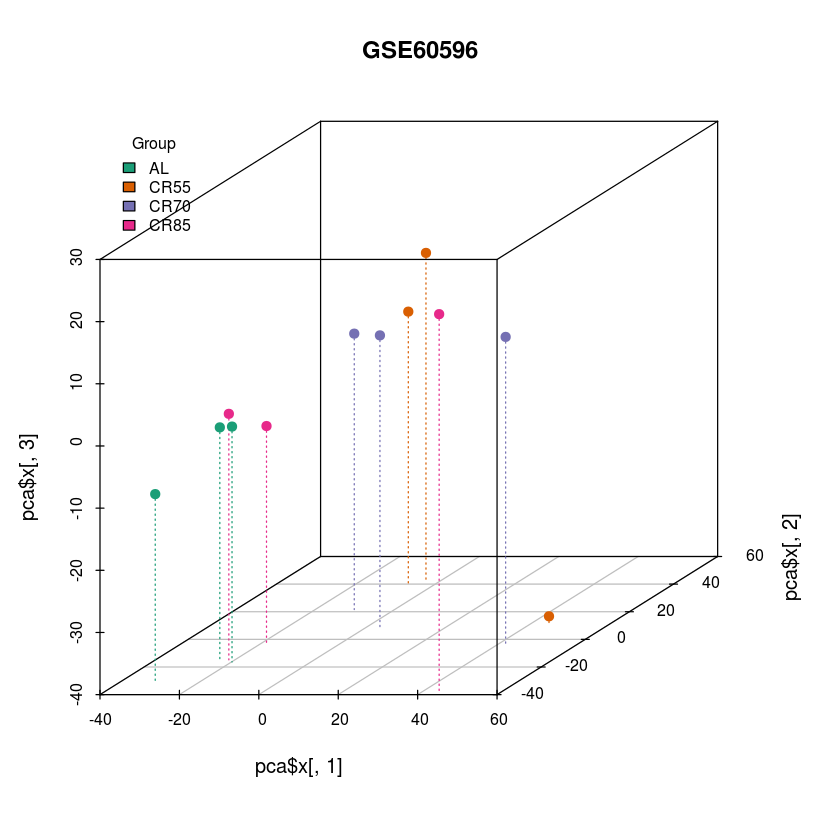

In [75]:
top_tables <- diff_expr(eset)